# 필요 라이브러리 불러오기

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import datetime

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import random

In [4]:
# 랜덤 시드 설정
seed_value = 2014

# Numpy의 랜덤 시드 설정
np.random.seed(seed_value)

# Tensorflow의 랜덤 시드 설정
tf.random.set_seed(seed_value)

# Python의 랜덤 시드 설정
random.seed(seed_value)

### 학습 결과 시각화 함수 정의

In [108]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()


# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

# 데이터 전처리 

필요한 정보를 생성하거나 필요 없는 정보를 제거 

In [7]:
# 주어진 데이터에서 시계열 정보들을 얻는다
def decomp_plot_sales(sales, Store_ID, Product_ID, sdate, edate, period, vis=False) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == Store_ID) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid, 'Date':temp['Date']})

    # 4개의 그래프로 나눠서 그리기
    # if vis:
    #     plt.figure(figsize=(15, 8))

    #     plt.subplot(4,1,1)
    #     plt.plot(result['Date'], result['observed'])
    #     plt.ylabel('observed')

    #     plt.subplot(4,1,2)
    #     plt.plot(result['Date'], result['trend'])
    #     plt.ylabel('trend')

    #     plt.subplot(4,1,3)
    #     plt.plot(result['Date'], result['seasonal'])
    #     plt.ylabel('seasonal')

    #     plt.subplot(4,1,4)
    #     plt.plot(result['Date'], result['residual'])
    #     plt.ylabel('residual')
    #     plt.show()

    return result

# 시즌 수치화
def get_season_enc(month):
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3
    
# 날짜 데이터로 변환
def get_date(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.dayofweek
    df['week'] = df['Date'].dt.isocalendar().week
    df['week'] = df['week'].astype('int')
    df['quarter']=df['Date'].dt.quarter
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['season'] = df['month'].apply(get_season_enc)

    return df

In [30]:
# 데이터 정제 
def get_dataset(oil_price, orders, sales, products, stores, Store_ID=44, product_ID=3):
    sales['Date'] = pd.to_datetime(sales['Date'] )
    oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
    orders['Date'] = pd.to_datetime(orders['Date'] )
    oil_price['dayWeek'] = oil_price['Date'].dt.dayofweek
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate()
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method= 'bfill')

    # print('oil_price 결측치 수', oil_price['WTI_Price'].isnull().sum())
    # 주말에 유가 가격이 주어지지 않는다, 따라서 주말 유가 가격은 금요일 가격을 따른다.
    new_oil_price = pd.DataFrame({
    'Date' : [0],
    'WTI_Price' : [0],
    'dayWeek' : [0]
    })

    n=0
    for i in range(len(oil_price)):
        new_oil_price.loc[i+n] = oil_price.loc[i]
        if oil_price['dayWeek'].loc[i]==4:
            new_oil_price.loc[i+n+1] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=1), oil_price['WTI_Price'].loc[i], 5]
            new_oil_price.loc[i+n+2] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=2), oil_price['WTI_Price'].loc[i], 6]
            n+=2

    new_oil_price['Date'] = pd.to_datetime(new_oil_price['Date'] )

    product_sales = pd.merge(sales, products, on='Product_ID')
    store_orders = pd.merge(stores, orders, on='Store_ID')

    dataset = pd.merge(product_sales, store_orders, on=['Store_ID', 'Date'])
    dataset = pd.merge(dataset, new_oil_price, on='Date', how='left')

    ####
    # 주어진 데이터에서 얻은 시계열 정보들을 추가한다
    if sales['Date'].isin(['2014-01-01']).sum() > 0 :
        decomp = decomp_plot_sales(sales, Store_ID, product_ID,'2014-01-01', '2017-02-28',7).reset_index(drop=True)
        decomp['trend'] = decomp['trend'].ffill()
        decomp['trend'] = decomp['trend'].bfill()
        dataset = pd.merge(dataset, decomp, on='Date', how='left')  

    if sales['Date'].isin(['2017-03-01']).sum() > 0 :
        decomp = decomp_plot_sales(sales, Store_ID, product_ID,'2017-03-01', '2017-03-31',7).reset_index(drop=True)
        decomp['trend'] = decomp['trend'].ffill()
        decomp['trend'] = decomp['trend'].bfill()
        dataset = pd.merge(dataset, decomp, on='Date', how='left')
    ####
    
    return dataset

## 목표는 2일 후 각 가게의 상품 수량 예측이다

이를 통해 2일 전 미리 예측된 수량을 주문할 수 있기 때문이다.

In [31]:
def preprocessing(dataset, Selected_Features, Store_ID=44, Product_ID=3):            # train set과 test set 공통으로 진행하기 위해
    dataset = get_date(dataset)
    dataset = dataset[(dataset['Store_ID']==Store_ID) & (dataset['Product_ID']==Product_ID)]
    dataset = dataset[Selected_Features]
    dataset = dataset.reset_index(drop=True)
    dataset['Target_Qty'] = dataset['Qty'].shift(periods=-2)
    dataset = dataset.iloc[:-2].reset_index(drop=True)
    return dataset

## LSTM을 사용하기 위해 데이터를 시간 정보가 포함된 3차원으로 변환한다

### 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * temporalize: 2차원을 3차원으로 만드는 함수
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [32]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [46]:
def Normalize(x_train, x_val, y_train, y_val):
    # 3차원 데이터에 스테일러 적용
    scaler_x = MinMaxScaler().fit(flatten(x_train)) # 2차원으로 변환하여 스케일러 생성
    x_train_s = scale(x_train, scaler_x)
    x_val_s = scale(x_val, scaler_x)

    # y에 대한 스케일링(최적화를 위해)
    scaler_y = MinMaxScaler()
    y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))

    return x_train_s, x_val_s, y_train_s, y_val, scaler_x, scaler_y

### 데이터 Loader 정의

In [95]:
def TrainLoader(oil_price, orders, sales, products, stores, Selected_Features, timesteps = 7, Store_ID=44, Product_ID=3):

    data = get_dataset(oil_price, orders, sales, products, stores, Store_ID=Store_ID, product_ID=Product_ID)

    dataset = preprocessing(data, Selected_Features, Store_ID=44, Product_ID=Product_ID)
    print(dataset.head())
    target = 'Target_Qty'
    x = dataset.drop([target], axis = 1)
    y = dataset.loc[:, target]

    timesteps = timesteps          # 7
    x2, y2 = temporalize(x, y, timesteps)

    val_size = timesteps * 7      # 4 * 2
    x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

    return x_train, x_val, y_train, y_val

def TestLoader(oil_price, orders, sales, products, stores, Selected_Features, timesteps = 7, Store_ID=44, Product_ID=3):

    data = get_dataset(oil_price, orders, sales, products, stores, Store_ID=Store_ID, product_ID=Product_ID)

    dataset = preprocessing(data, Selected_Features, Store_ID=44, Product_ID=Product_ID)
    print(dataset.head())
    target = 'Target_Qty'
    x = dataset.drop([target], axis = 1)
    y = dataset.loc[:, target]

    timesteps = timesteps          # 7
    x2, y2 = temporalize(x, y, timesteps)


    return x2, y2

# 데이터 불러오기

In [96]:
path = './data/'

In [97]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [98]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [167]:
stores['Store_ID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [169]:
products['Product_ID'].unique()

array([20, 27, 16, 15, 32, 38, 29, 11, 10, 24,  5,  8,  7,  3, 12, 42],
      dtype=int64)

In [99]:
Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']
timesteps = 7

x_train, x_val, y_train, y_val = TrainLoader(oil_price, orders, sales, products, stores, 
                                            Selected_Features, timesteps = timesteps, Store_ID=44, Product_ID=3)


   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422   9853.0   
1  2014      1     1        4       3           0           4167   8647.0   
2  2014      1     1        5       3           1           5341  15153.0   
3  2014      1     1        6       3           1           5123  15606.0   
4  2014      1     2        0       3           0           3917   7900.0   

          trend     seasonal  Target_Qty  
0   9192.428571   349.377966     15153.0  
1   9192.428571  2061.789885     15606.0  
2   9192.428571  1623.761203      7900.0  
3  10449.571429   203.920611      7188.0  
4   9985.714286 -1265.746636      8800.0  


In [100]:

x_test, y_test = TestLoader(oil_price_test, orders_test, sales_test, products, stores, 
                                            Selected_Features, timesteps = timesteps, Store_ID=44, Product_ID=3)


   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2017      3     9        2       0           0           4146  10153.0   
1  2017      3     9        3       0           0           3882   8918.0   
2  2017      3     9        4       0           0           4483  10257.0   
3  2017      3     9        5       0           1           5382  16991.0   
4  2017      3     9        6       0           1           5423  18304.0   

          trend     seasonal  Target_Qty  
0  11628.000000 -2417.285714     10257.0  
1  11628.000000 -3213.619048     16991.0  
2  11628.000000 -1037.476190     18304.0  
3  11628.000000  5200.523810      8413.0  
4  11410.714286  7677.488095      8360.0  


In [132]:
# total dataLoader 

def Total_Loader(oil_price, orders, sales, products, stores,
                 Selected_Features, timesteps = timesteps, Store_ID=44, Product_ID=3):
    x_train, x_val, y_train, y_val = TrainLoader(oil_price, orders, sales, products, stores, 
                                            Selected_Features, timesteps = timesteps, Store_ID=Store_ID, Product_ID=Product_ID)
    x_test, y_test = TestLoader(oil_price_test, orders_test, sales_test, products, stores, 
                                            Selected_Features, timesteps = timesteps, Store_ID=Store_ID, Product_ID=Product_ID)
    
    x_train_s, x_val_s, y_train_s, y_val, scaler_x, scaler_y = Normalize(x_train, x_val, y_train, y_val)
    x_test_s = scale(x_test, scaler_x)
    
    return x_train_s, x_val_s, y_train_s, y_val, x_test_s, y_test, scaler_x, scaler_y

# 모델링 

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [128]:

def training_process(timesteps, x_train_s, y_train_s, Epoch=200):
    n_features = x_train_s.shape[2]

    clear_session()

    
    model = Sequential([
                     LSTM(16, input_shape = (timesteps, n_features), return_sequences=True),
                     Flatten(),
                     Dense(1)
                     ])
    
    '''
    MAE : 405.31802056760205
    MAPE: 0.04006783507670754
    R2  : 0.9813271255550304
    '''
    
    # model = Sequential([
    #                     Bidirectional(LSTM(32, return_sequences=True, input_shape = (timesteps, n_features))),
    #                     Bidirectional(LSTM(32,  return_sequences=False)),
    #                     Flatten(),
    #                     Dense(1),
    #                     ])
    '''
    MAE : 592.5261878188776
    MAPE: 0.057367112861109786
    R2  : 0.9541670077953223
    '''
    
    # R2 : 0.94
    # model = Sequential([
    #                     Conv1D(filters=32, kernel_size=3,strides=1, padding='causal',activation='relu', input_shape = (timesteps, n_features)),
    #                     Bidirectional(LSTM(32, return_sequences=True)),
    #                     Bidirectional(LSTM(32,  return_sequences=False)),
    #                     Flatten(),
    #                     Dense(1),
    #                     ])
    '''
    MAE : 755.7705875318877
    MAPE: 0.07564989694794452
    R2  : 0.9331507664678962
    '''

    model.compile(optimizer = Adam(learning_rate = 0.01), loss='mae')
    # model.summary()

    es = EarlyStopping(monitor='val_loss',
                    min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                    patience=100,  # 개선 없는 epoch 얼마나 기다려 줄거야
                    mode='min',
                    verbose=1,
                    restore_best_weights=True)

    lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                    patience=10,
                                    verbose=1,
                                    factor=0.5, # 0.5를 lr에 곱해주겠다
                                    min_lr=0.000001) # 가장 작은 lr
    
    hist = model.fit(x_train_s, y_train_s, epochs=Epoch, validation_split=.2, callbacks=[es, lr_reduction]).history
    
    dl_history_plot(hist)
    
    return model
    
    

### **1) 상품 : 3 - Beverage** 에 대해 Train 및 Test 수행

   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422   9853.0   
1  2014      1     1        4       3           0           4167   8647.0   
2  2014      1     1        5       3           1           5341  15153.0   
3  2014      1     1        6       3           1           5123  15606.0   
4  2014      1     2        0       3           0           3917   7900.0   

          trend     seasonal  Target_Qty  
0   9192.428571   349.377966     15153.0  
1   9192.428571  2061.789885     15606.0  
2   9192.428571  1623.761203      7900.0  
3  10449.571429   203.920611      7188.0  
4   9985.714286 -1265.746636      8800.0  
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2017      3     9        2       0           0           4146  10153.0   
1  2017      3     9        3       0           0           3882   8918.0   
2  2017      3     9        4       0           

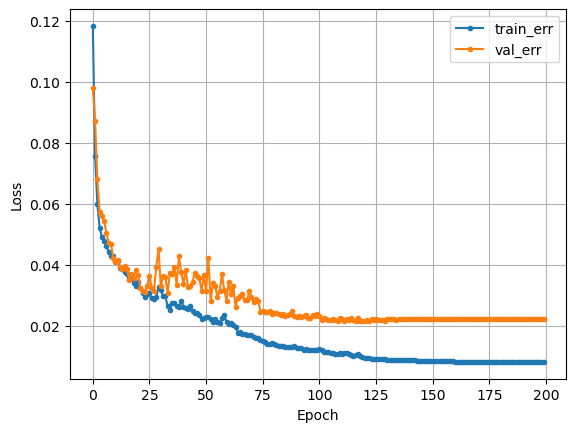

In [137]:
Store_ID=44             # 44번 가게 
Product_ID=3            # 3번 상품에 대해 
timesteps = 7           # 7일씩 예측 
Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']



x_train_s, x_val_s, y_train_s, y_val, x_test_s, y_test, scaler_x, scaler_y = \
    Total_Loader(oil_price, orders, sales, products, stores,
                 Selected_Features, timesteps = timesteps, Store_ID=Store_ID, Product_ID=Product_ID)
    
    
model = training_process(timesteps, x_train_s, y_train_s, Epoch=200)

## 예측 및 평가 시각화

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
전체 수량:  536615
MAE : 292.77
MAPE: 2.98 %
R2  : 0.9896


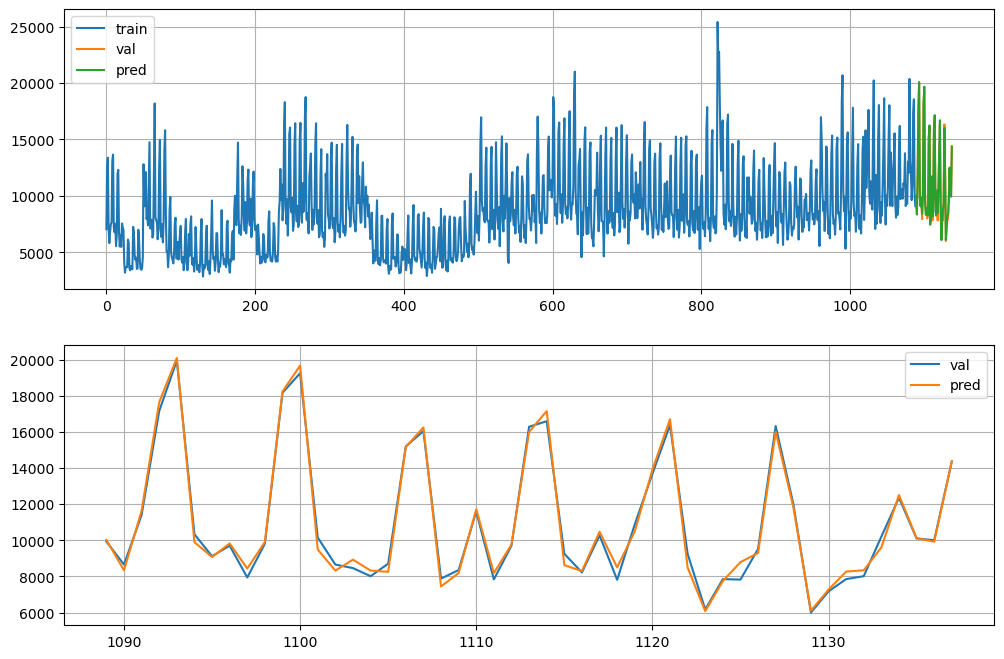

In [158]:
pred = model.predict(x_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('전체 수량: ', int(y_val.sum()))
print('MAE : {:.2f}'.format(mean_absolute_error(y_val, pred)))
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(y_val, pred)*100))
print('R2  : {:.4f}'.format(r2_score(y_val, pred)))

plot_model_result(y_train, y_val, pred)

### 테스트셋 평가 결과

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


전체 수량:  264703
MAE : 929.77
MAPE: 8.35 %
R2  : 0.9220


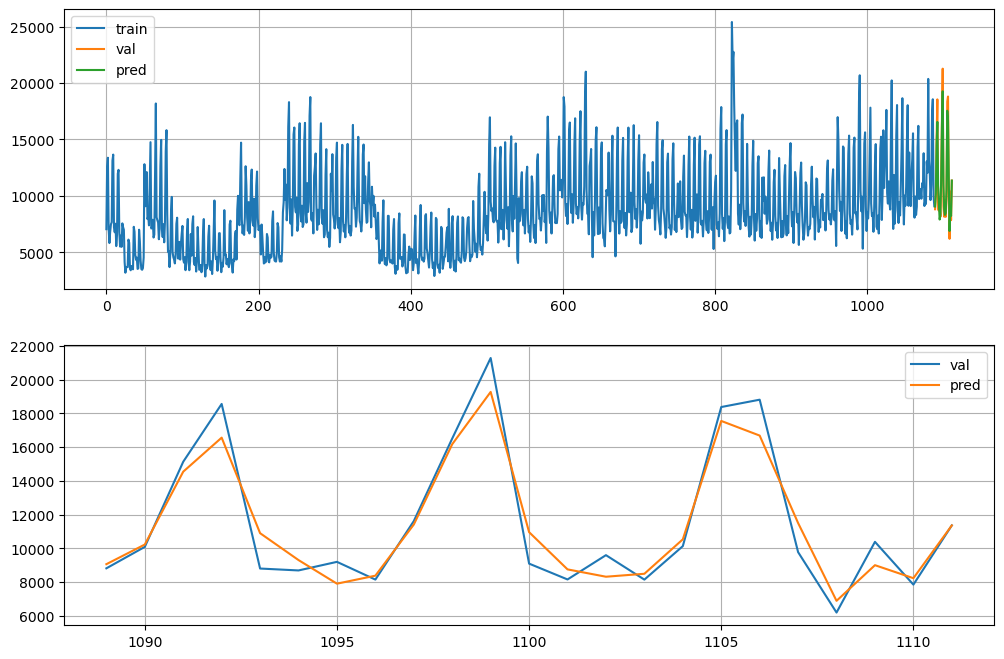

In [159]:
pred = model.predict(x_test_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('전체 수량: ', int(y_test.sum()))
print('MAE : {:.2f}'.format(mean_absolute_error(y_test, pred)))
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(y_test, pred)*100))
print('R2  : {:.4f}'.format(r2_score(y_test, pred)))

plot_model_result(y_train, y_test, pred)

### **2) 상품 : 12 - Milk** 에 대해 Train 및 Test 수행

   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422   9647.0   
1  2014      1     1        4       3           0           4167   8879.0   
2  2014      1     1        5       3           1           5341  14188.0   
3  2014      1     1        6       3           1           5123  14490.0   
4  2014      1     2        0       3           0           3917   7614.0   

          trend     seasonal  Target_Qty  
0   8848.857143   -13.491675     14188.0  
1   8848.857143  1813.618754     14490.0  
2   8848.857143  1556.983945      7614.0  
3  10089.285714   137.196726      7124.0  
4   9672.714286  -948.181116      8683.0  
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2017      3     9        2       0           0           4146  11307.0   
1  2017      3     9        3       0           0           3882   9761.0   
2  2017      3     9        4       0           

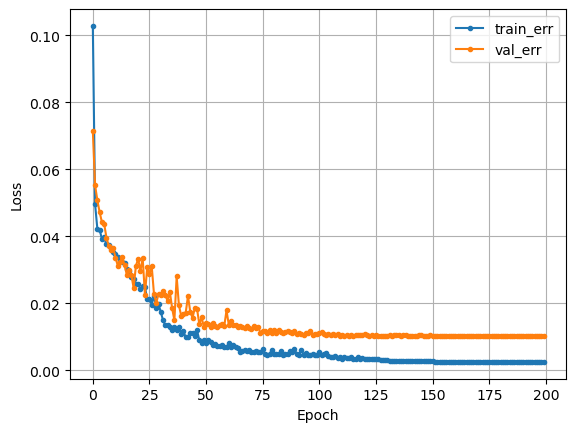

In [160]:
Store_ID=44             # 44번 가게 
Product_ID=12            # 3번 상품에 대해 
timesteps = 7           # 7일씩 예측 
Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']



x_train_s, x_val_s, y_train_s, y_val, x_test_s, y_test, scaler_x, scaler_y = \
    Total_Loader(oil_price, orders, sales, products, stores,
                 Selected_Features, timesteps = timesteps, Store_ID=Store_ID, Product_ID=Product_ID)
    
    
model = training_process(timesteps, x_train_s, y_train_s, Epoch=200)

## 예측 및 평가 시각화

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
전체 수량:  539072
MAE : 140.88
MAPE: 1.41 %
R2  : 0.9964


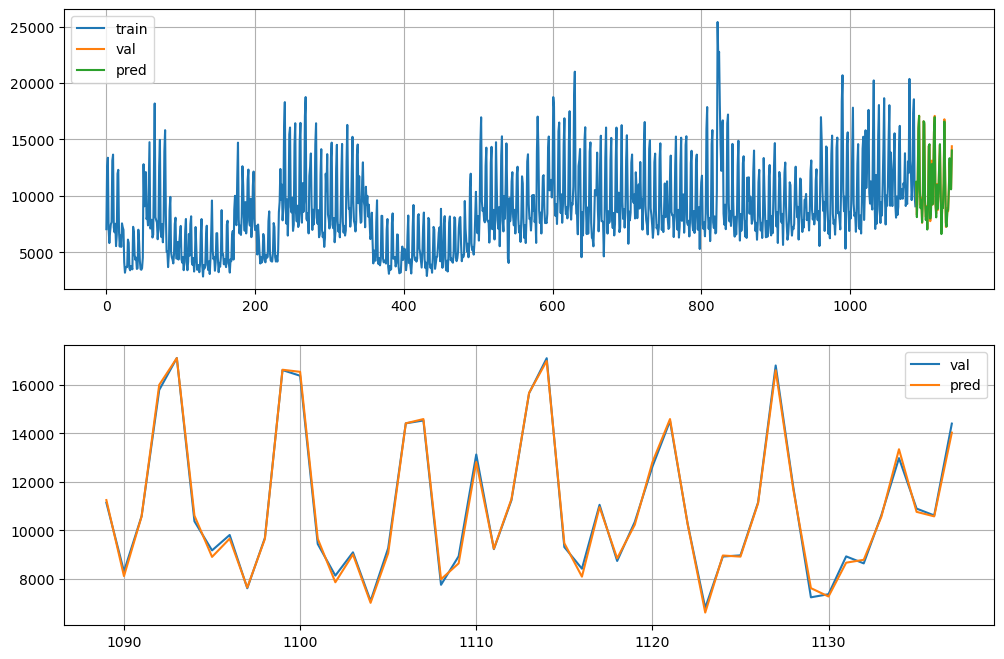

In [161]:
pred = model.predict(x_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('전체 수량: ', int(y_val.sum()))
print('MAE : {:.2f}'.format(mean_absolute_error(y_val, pred)))
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(y_val, pred)*100))
print('R2  : {:.4f}'.format(r2_score(y_val, pred)))

plot_model_result(y_train, y_val, pred)

### 테스트셋 평가 결과

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
전체 수량:  249212
MAE : 543.86
MAPE: 5.23 %
R2  : 0.9638


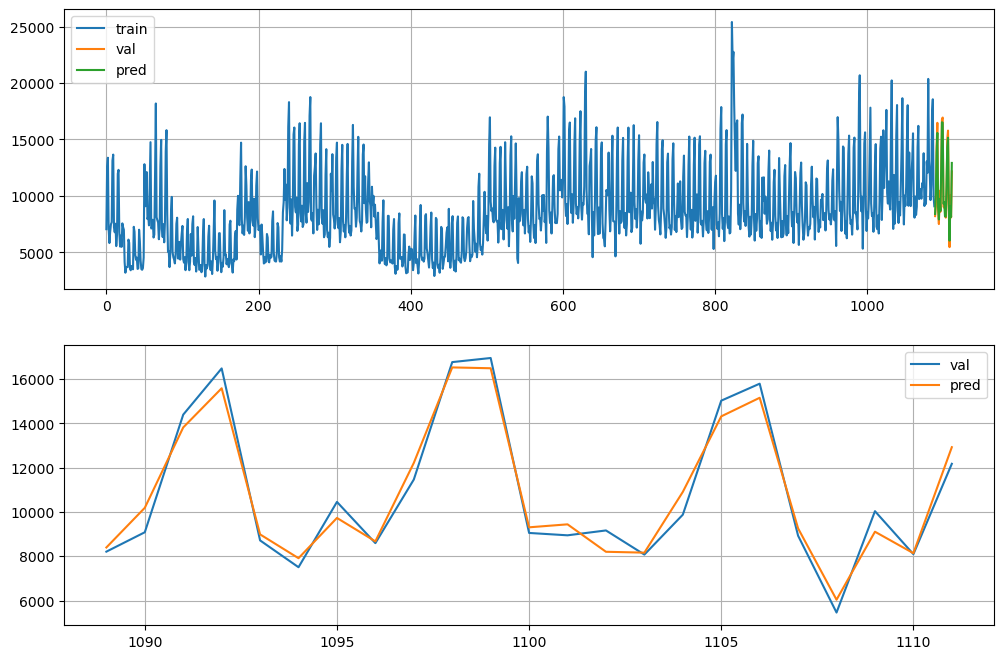

In [162]:
pred = model.predict(x_test_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('전체 수량: ', int(y_test.sum()))
print('MAE : {:.2f}'.format(mean_absolute_error(y_test, pred)))
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(y_test, pred)*100))
print('R2  : {:.4f}'.format(r2_score(y_test, pred)))

plot_model_result(y_train, y_test, pred)

### **3) 상품 : 42 - Agricultural products**

   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2014      1     1        3       3           0           4422  76.0   
1  2014      1     1        4       3           0           4167  74.0   
2  2014      1     1        5       3           1           5341  78.0   
3  2014      1     1        6       3           1           5123  88.0   
4  2014      1     2        0       3           0           3917  65.0   

       trend   seasonal  Target_Qty  
0  72.857143  -0.937227        78.0  
1  72.857143   7.709985        88.0  
2  72.857143  13.207858        65.0  
3  76.000000  20.790125        78.0  
4  76.285714 -23.015624        73.0  
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2017      3     9        2       0           0           4146  106.0   
1  2017      3     9        3       0           0           3882  138.0   
2  2017      3     9        4       0           0           4483  106.0   
3  2017      3     9       

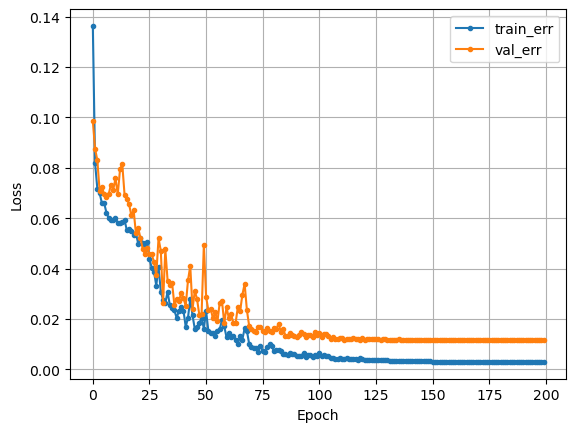

In [163]:
Store_ID=44             # 44번 가게 
Product_ID=42            # 3번 상품에 대해 
timesteps = 7           # 7일씩 예측 
Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']



x_train_s, x_val_s, y_train_s, y_val, x_test_s, y_test, scaler_x, scaler_y = \
    Total_Loader(oil_price, orders, sales, products, stores,
                 Selected_Features, timesteps = timesteps, Store_ID=Store_ID, Product_ID=Product_ID)
    
    
model = training_process(timesteps, x_train_s, y_train_s, Epoch=200)

## 예측 및 평가 시각화

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
전체 수량:  4313
MAE : 1.08
MAPE: 1.27 %
R2  : 0.9920


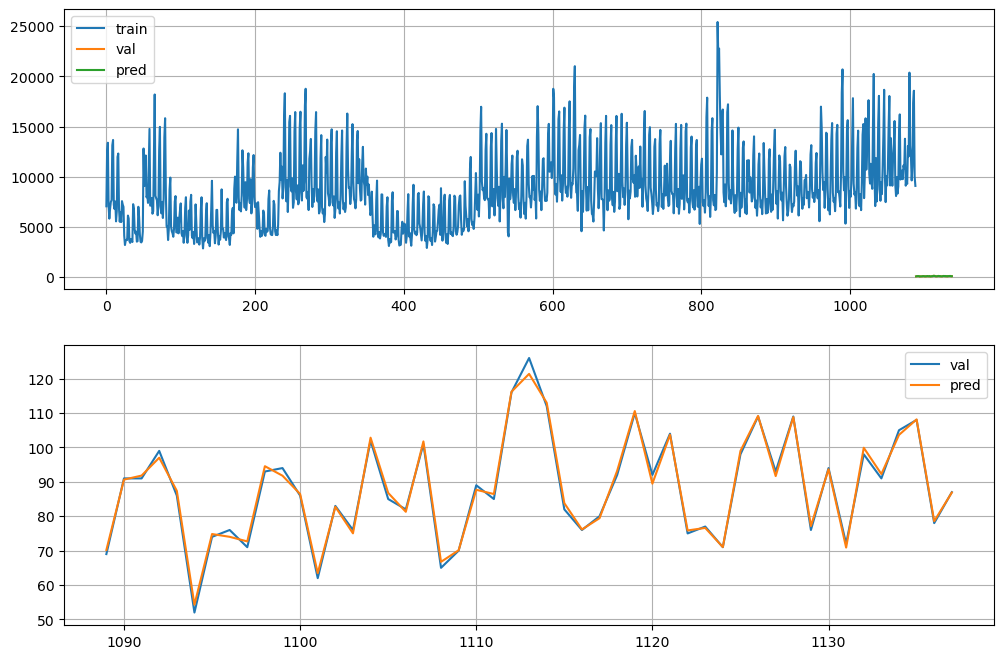

In [164]:
pred = model.predict(x_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('전체 수량: ', int(y_val.sum()))
print('MAE : {:.2f}'.format(mean_absolute_error(y_val, pred)))
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(y_val, pred)*100))
print('R2  : {:.4f}'.format(r2_score(y_val, pred)))

plot_model_result(y_train, y_val, pred)

### 테스트셋 평가 결과

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  2562
MAE : 4.79
MAPE: 4.39 %
R2  : 0.8775


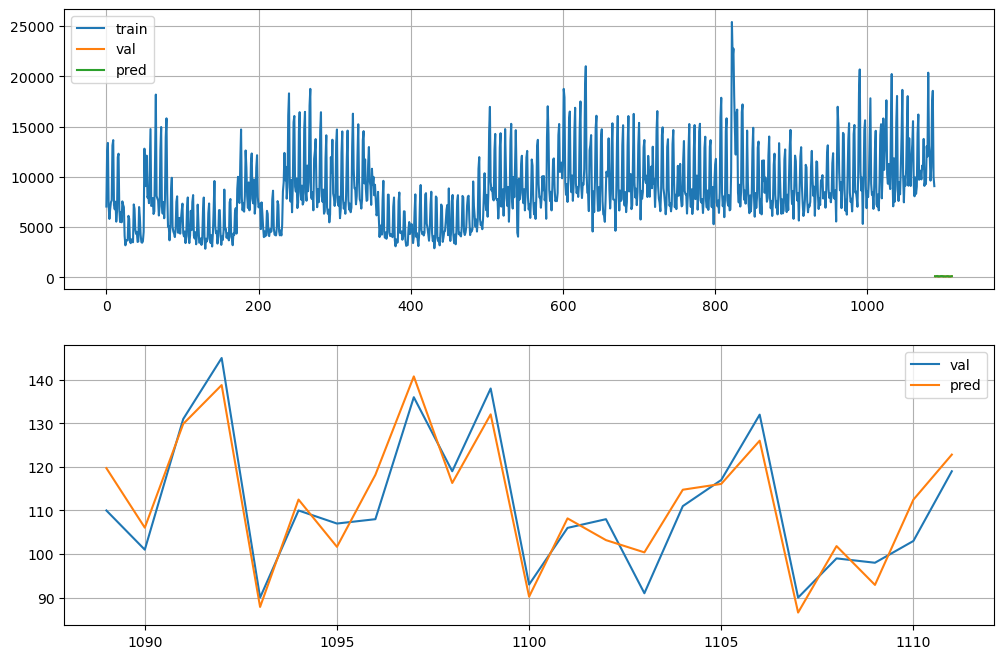

In [165]:
pred = model.predict(x_test_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('전체 수량: ', int(y_test.sum()))
print('MAE : {:.2f}'.format(mean_absolute_error(y_test, pred)))
print('MAPE: {:.2f} %'.format(mean_absolute_percentage_error(y_test, pred)*100))
print('R2  : {:.4f}'.format(r2_score(y_test, pred)))

plot_model_result(y_train, y_test, pred)

In [170]:
all_product_ID_list = sorted(list(products['Product_ID'].unique()))

all_product_ID_list

[3, 5, 7, 8, 10, 11, 12, 15, 16, 20, 24, 27, 29, 32, 38, 42]

   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422   9853.0   
1  2014      1     1        4       3           0           4167   8647.0   
2  2014      1     1        5       3           1           5341  15153.0   
3  2014      1     1        6       3           1           5123  15606.0   
4  2014      1     2        0       3           0           3917   7900.0   

          trend     seasonal  Target_Qty  
0   9192.428571   349.377966     15153.0  
1   9192.428571  2061.789885     15606.0  
2   9192.428571  1623.761203      7900.0  
3  10449.571429   203.920611      7188.0  
4   9985.714286 -1265.746636      8800.0  
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2017      3     9        2       0           0           4146  10153.0   
1  2017      3     9        3       0           0           3882   8918.0   
2  2017      3     9        4       0           

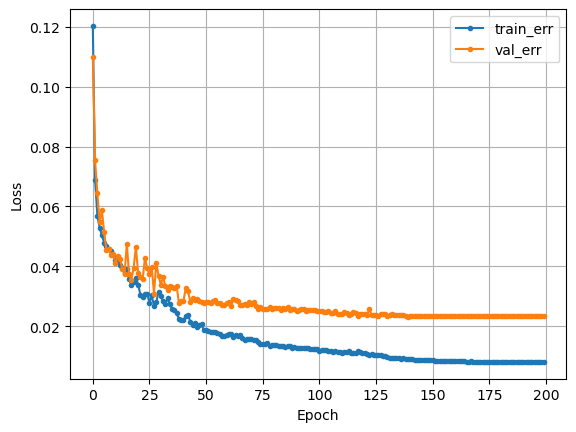

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Product_ID:  3
전체 수량:  536615
MAE : 229.49
MAPE: 2.25 %
R2  : 0.9938


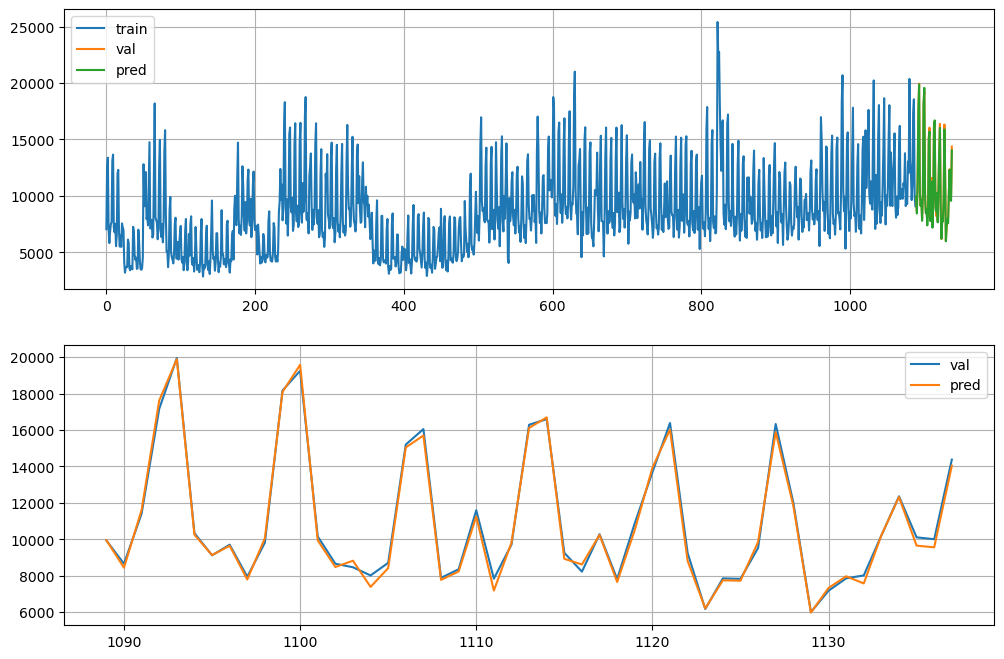

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
전체 수량:  264703
MAE : 787.85
MAPE: 7.63 %
R2  : 0.9422
   year  month  week  weekday  season  is_weekend  CustomerCount       Qty  \
0  2014      1     1        3       3           0           4422  1302.470   
1  2014      1     1        4       3           0           4167  1243.054   
2  2014      1     1        5       3           1           5341  1882.780   
3  2014      1     1        6       3           1           5123  2029.317   
4  2014      1     2        0       3           0           3917   992.359   

         trend    seasonal  Target_Qty  
0  1197.599286   29.276979    1882.780  
1  1197.599286  293.606511    2029.317  
2  1197.599286  231.266207     992.359  
3  1376.232857   37.211907     933.215  
4  1319.518000 -191.728784    1250.435  
   year  month  week  weekday  season  is_weekend  CustomerCount       Qty  \
0  2017      3     9        2       0           0           4146  1745.503   
1  2017      3     9        3       0

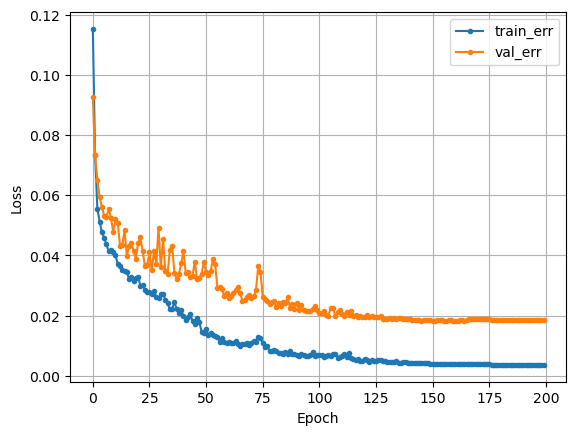

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Product_ID:  5
전체 수량:  90734
MAE : 37.12
MAPE: 2.15 %
R2  : 0.9913


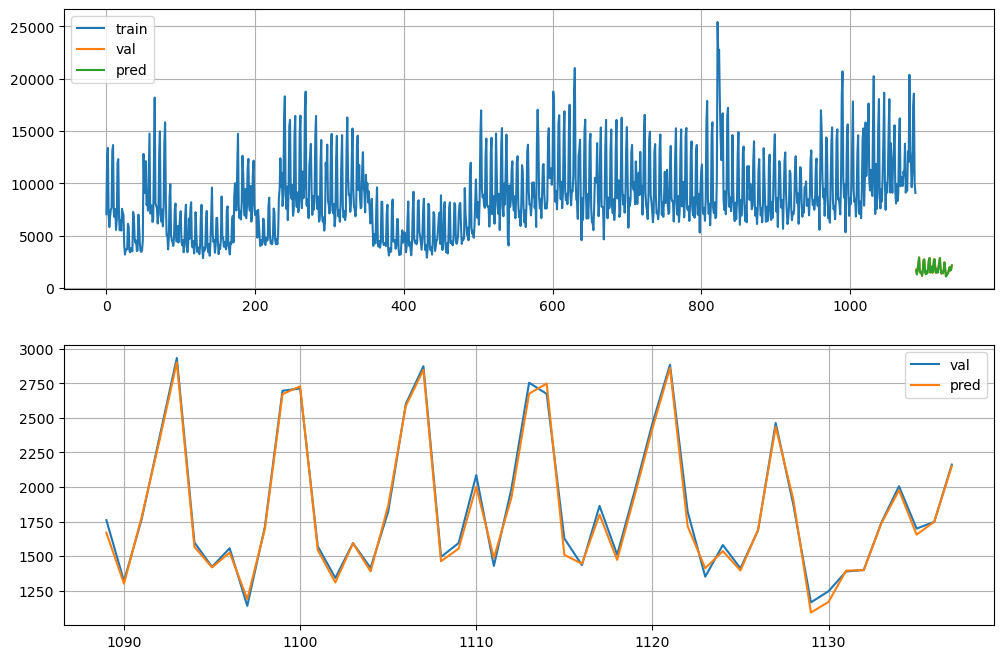

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  43360
MAE : 126.38
MAPE: 7.17 %
R2  : 0.9475
   year  month  week  weekday  season  is_weekend  CustomerCount     Qty  \
0  2014      1     1        3       3           0           4422  3181.0   
1  2014      1     1        4       3           0           4167  3036.0   
2  2014      1     1        5       3           1           5341  4466.0   
3  2014      1     1        6       3           1           5123  4582.0   
4  2014      1     2        0       3           0           3917  2536.0   

         trend    seasonal  Target_Qty  
0  2896.285714  -64.673098      4466.0  
1  2896.285714  323.711652      4582.0  
2  2896.285714  370.561976      2536.0  
3  3325.285714   96.887760      2473.0  
4  3197.714286 -196.970254      3003.0  
   year  month  week  weekday  season  is_weekend  CustomerCount     Qty  \
0  2017      3     9        2       0           0           4146  2869.0   
1  2017      3     9        3       0           0     

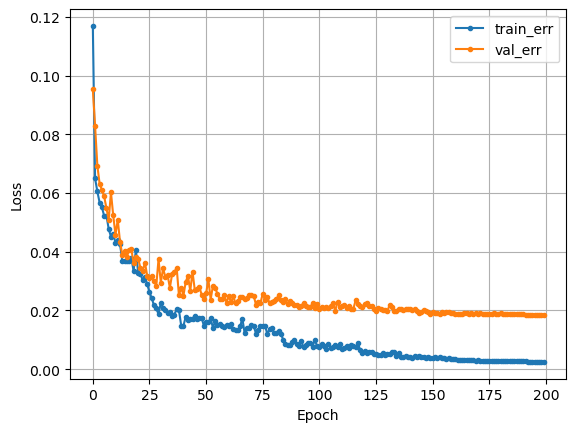

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Product_ID:  7
전체 수량:  130533
MAE : 47.34
MAPE: 1.81 %
R2  : 0.9900


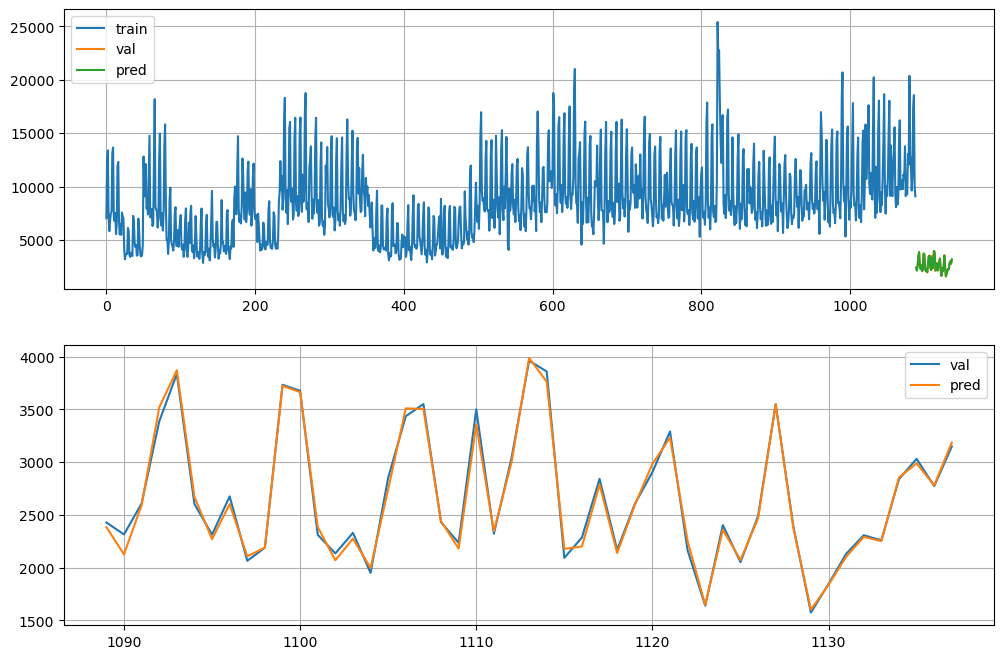

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  59203
MAE : 100.12
MAPE: 3.81 %
R2  : 0.9707
   year  month  week  weekday  season  is_weekend  CustomerCount     Qty  \
0  2014      1     1        3       3           0           4422  2991.0   
1  2014      1     1        4       3           0           4167  2694.0   
2  2014      1     1        5       3           1           5341  4355.0   
3  2014      1     1        6       3           1           5123  4228.0   
4  2014      1     2        0       3           0           3917  2323.0   

         trend    seasonal  Target_Qty  
0  2676.857143   39.659174      4355.0  
1  2676.857143  536.174511      4228.0  
2  2676.857143  461.019326      2323.0  
3  3050.857143   45.432218      2147.0  
4  2919.000000 -348.741127      2618.0  
   year  month  week  weekday  season  is_weekend  CustomerCount     Qty  \
0  2017      3     9        2       0           0           4146  3031.0   
1  2017      3     9        3       0           0     

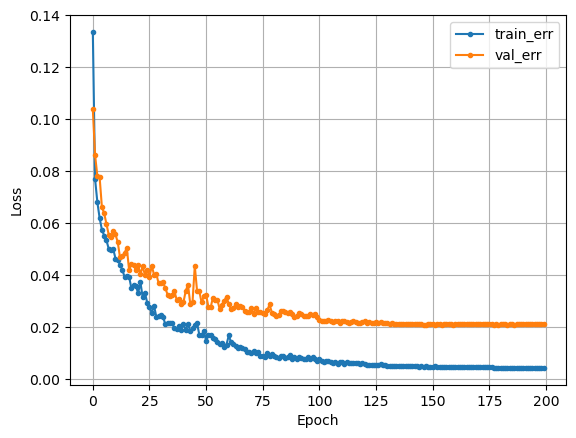

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Product_ID:  8
전체 수량:  144756
MAE : 46.54
MAPE: 1.62 %
R2  : 0.9946


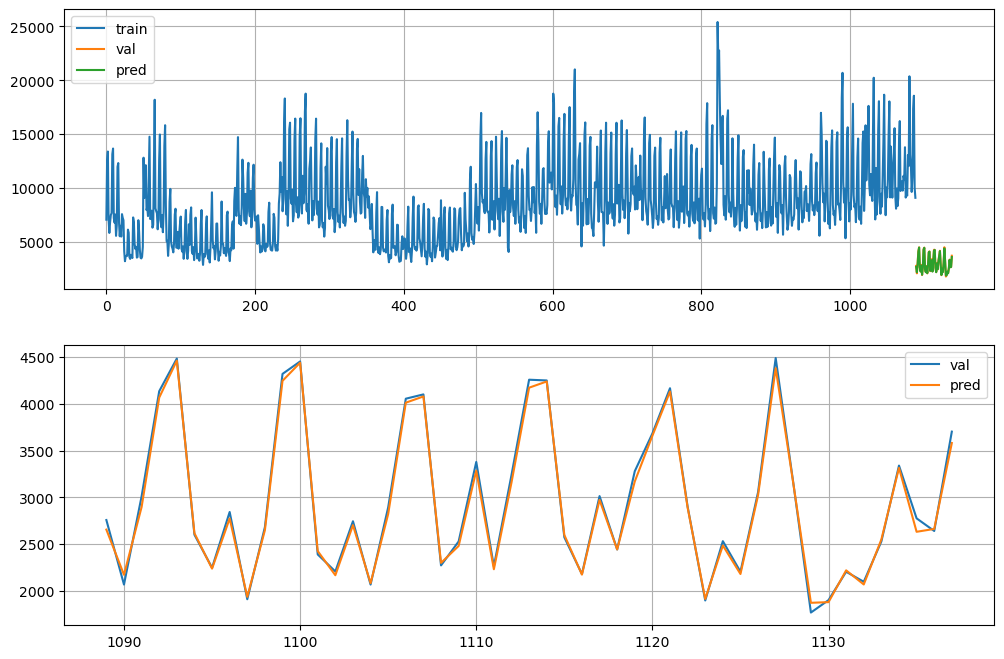

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
전체 수량:  70711
MAE : 87.05
MAPE: 2.67 %
R2  : 0.9854
   year  month  week  weekday  season  is_weekend  CustomerCount     Qty  \
0  2014      1     1        3       3           0           4422   780.0   
1  2014      1     1        4       3           0           4167   677.0   
2  2014      1     1        5       3           1           5341  1126.0   
3  2014      1     1        6       3           1           5123  1118.0   
4  2014      1     2        0       3           0           3917   596.0   

        trend    seasonal  Target_Qty  
0  687.428571  -11.734780      1126.0  
1  687.428571  133.245939      1118.0  
2  687.428571  143.674772       596.0  
3  785.000000   40.608570       515.0  
4  740.428571  -89.691082       683.0  
   year  month  week  weekday  season  is_weekend  CustomerCount     Qty  \
0  2017      3     9        2       0           0           4146   859.0   
1  2017      3     9        3       0           0           3

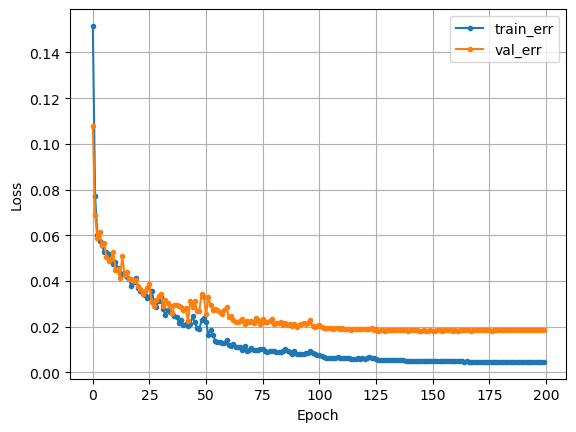

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Product_ID:  10
전체 수량:  32048
MAE : 11.30
MAPE: 1.85 %
R2  : 0.9940


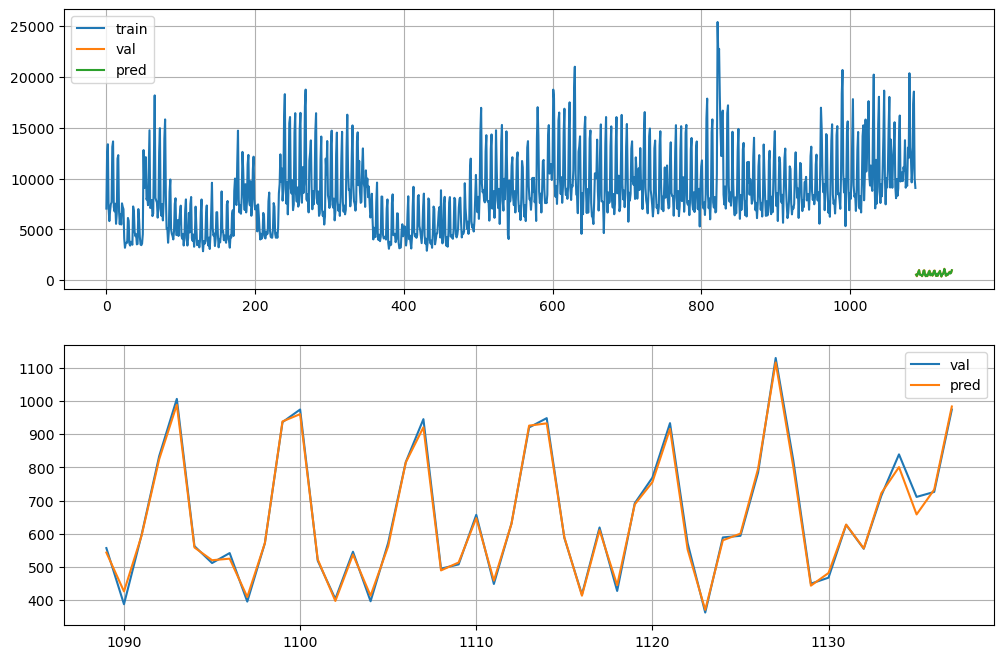

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  14574
MAE : 27.22
MAPE: 4.42 %
R2  : 0.9731
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422  600.931   
1  2014      1     1        4       3           0           4167  621.938   
2  2014      1     1        5       3           1           5341  883.348   
3  2014      1     1        6       3           1           5123  854.104   
4  2014      1     2        0       3           0           3917  429.764   

        trend   seasonal  Target_Qty  
0  532.173571 -13.311648     883.348  
1  532.173571  78.657580     854.104  
2  532.173571  51.862065     429.764  
3  607.034000  22.138479     335.130  
4  580.689286 -59.052270     524.023  
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2017      3     9        2       0           0           4146  484.250   
1  2017      3     9        3       0           0          

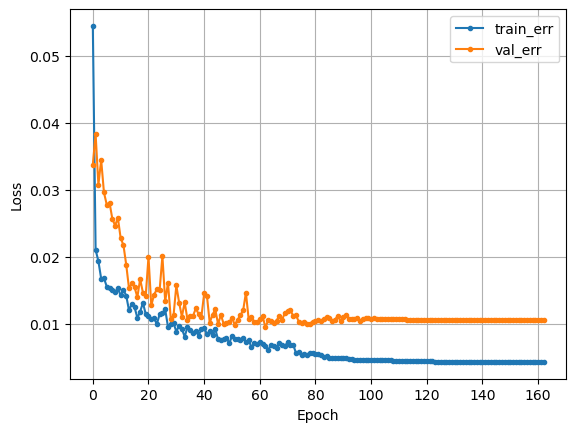

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  11
전체 수량:  23479
MAE : 57.46
MAPE: 13.63 %
R2  : 0.6946


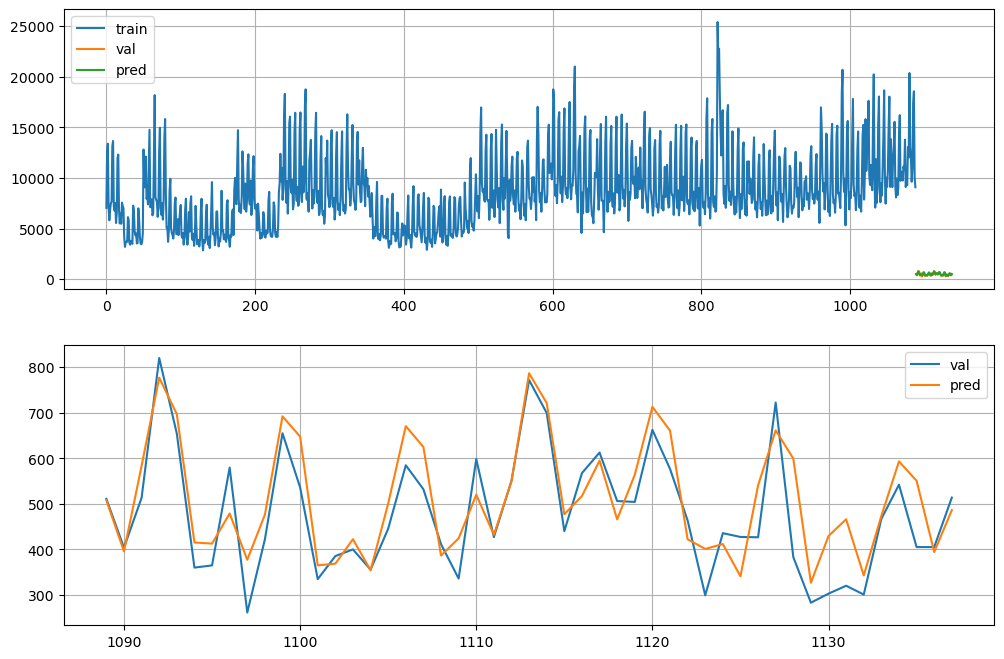

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  9816
MAE : 76.88
MAPE: 21.95 %
R2  : 0.1166
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422   9647.0   
1  2014      1     1        4       3           0           4167   8879.0   
2  2014      1     1        5       3           1           5341  14188.0   
3  2014      1     1        6       3           1           5123  14490.0   
4  2014      1     2        0       3           0           3917   7614.0   

          trend     seasonal  Target_Qty  
0   8848.857143   -13.491675     14188.0  
1   8848.857143  1813.618754     14490.0  
2   8848.857143  1556.983945      7614.0  
3  10089.285714   137.196726      7124.0  
4   9672.714286  -948.181116      8683.0  
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2017      3     9        2       0           0           4146  11307.0   
1  2017      3     9        3      

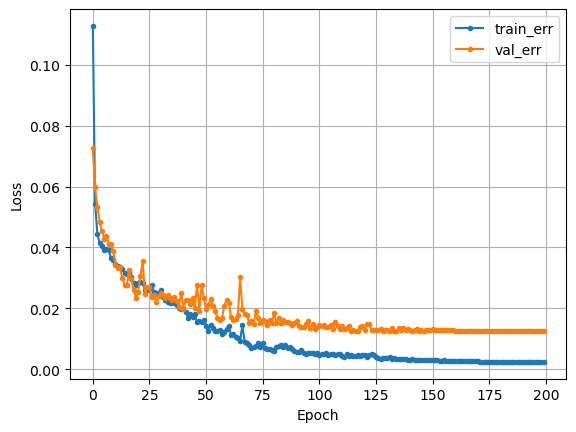

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  12
전체 수량:  539072
MAE : 227.01
MAPE: 2.26 %
R2  : 0.9920


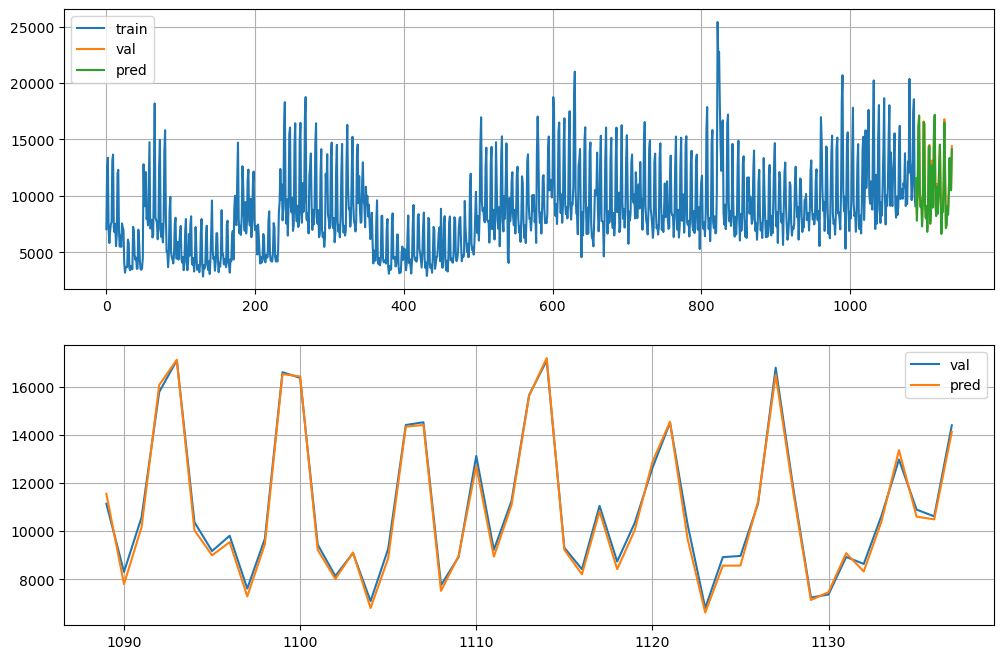

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
전체 수량:  249212
MAE : 518.37
MAPE: 4.81 %
R2  : 0.9670
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2014      1     1        3       3           0           4422   37.0   
1  2014      1     1        4       3           0           4167  105.0   
2  2014      1     1        5       3           1           5341   73.0   
3  2014      1     1        6       3           1           5123   42.0   
4  2014      1     2        0       3           0           3917   65.0   

       trend   seasonal  Target_Qty  
0  48.000000  12.386555        73.0  
1  48.000000   0.572357        42.0  
2  48.000000 -14.167741        65.0  
3  51.714286  -2.401190        14.0  
4  53.428571 -12.146835        26.0  
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2017      3     9        2       0           0           4146   45.0   
1  2017      3     9        3       0           0           3882   79.0   
2  2

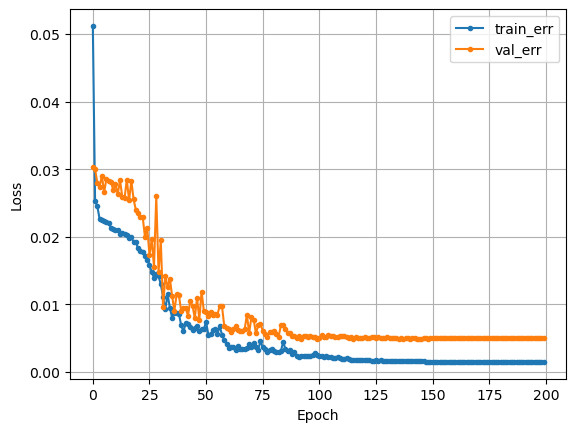

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  15
전체 수량:  6485
MAE : 8.53
MAPE: 7.67 %
R2  : 0.9830


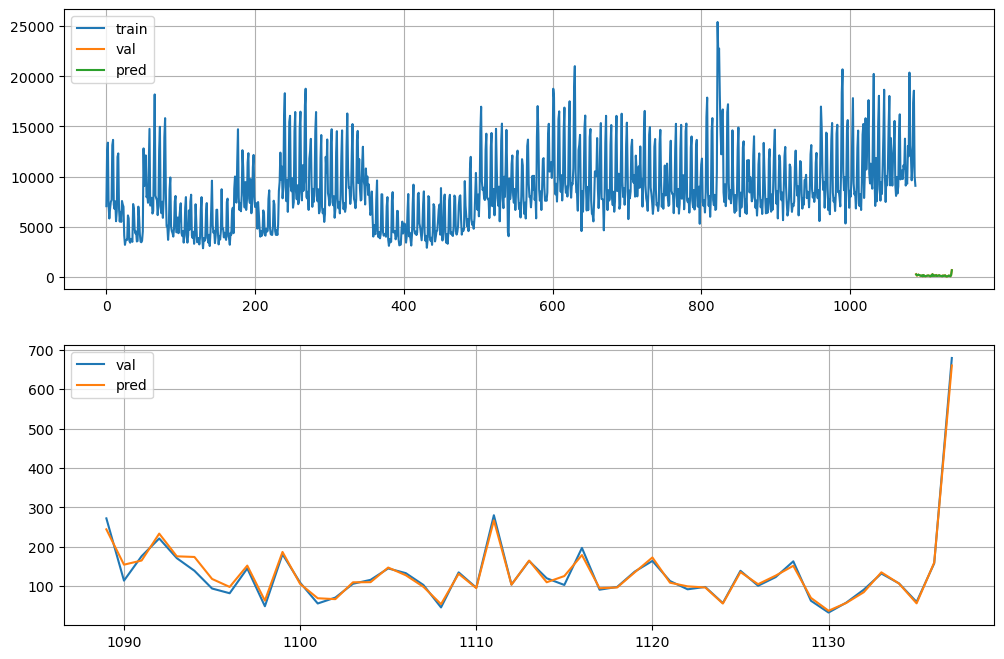

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  2058
MAE : 5.78
MAPE: 7.07 %
R2  : 0.9610
   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2014      1     1        3       3           0           4422  42.0   
1  2014      1     1        4       3           0           4167  24.0   
2  2014      1     1        5       3           1           5341  42.0   
3  2014      1     1        6       3           1           5123  61.0   
4  2014      1     2        0       3           0           3917  20.0   

       trend   seasonal  Target_Qty  
0  30.285714  10.394454        42.0  
1  30.285714  13.789722        61.0  
2  30.285714   2.940691        20.0  
3  35.142857  -1.730041        23.0  
4  32.285714  -7.693455        34.0  
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2017      3     9        2       0           0           4146   99.0   
1  2017      3     9        3       0           0           3882  109.0   
2  2017      3

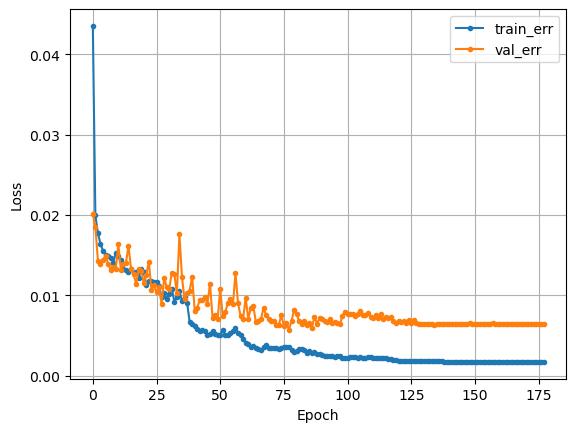

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  16
전체 수량:  5289
MAE : 7.37
MAPE: 7.09 %
R2  : 0.9393


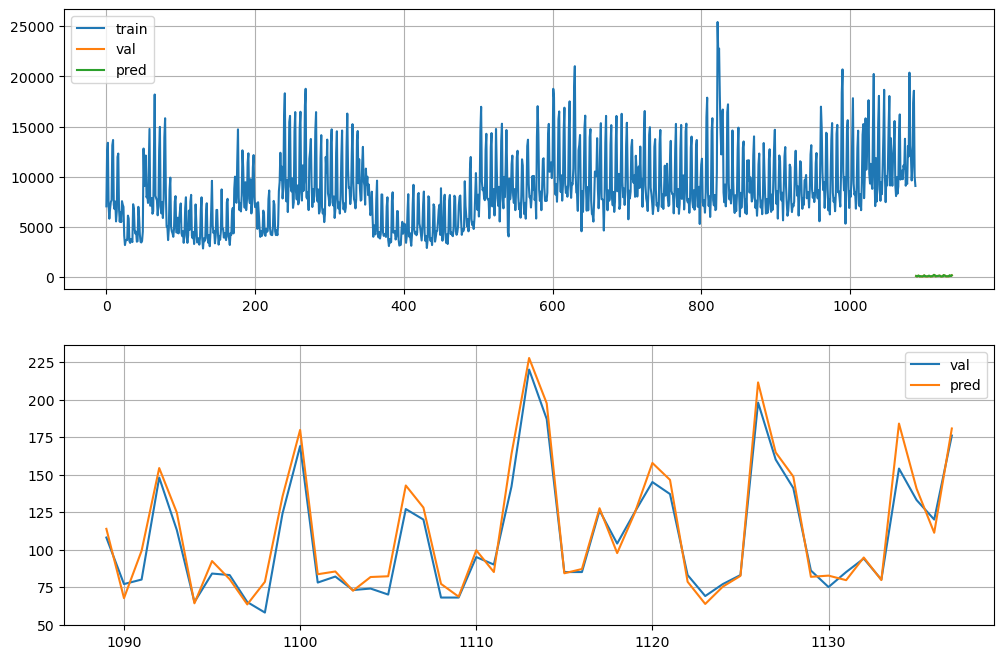

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  3232
MAE : 42.62
MAPE: 39.43 %
R2  : 0.6052
   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2014      1     1        3       3           0           4422  11.0   
1  2014      1     1        4       3           0           4167   7.0   
2  2014      1     1        5       3           1           5341  18.0   
3  2014      1     1        6       3           1           5123  10.0   
4  2014      1     2        0       3           0           3917  10.0   

       trend  seasonal  Target_Qty  
0   8.428571  4.008153        18.0  
1   8.428571  5.264069        10.0  
2   8.428571  2.081270        10.0  
3   9.571429 -3.351657         3.0  
4  11.142857 -4.155664         8.0  
   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2017      3     9        2       0           0           4146  27.0   
1  2017      3     9        3       0           0           3882  18.0   
2  2017      3     9 

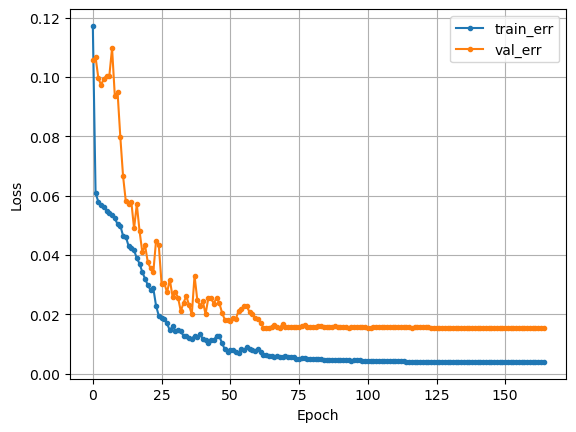

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Product_ID:  20
전체 수량:  1849
MAE : 10.06
MAPE: 28.10 %
R2  : 0.4176


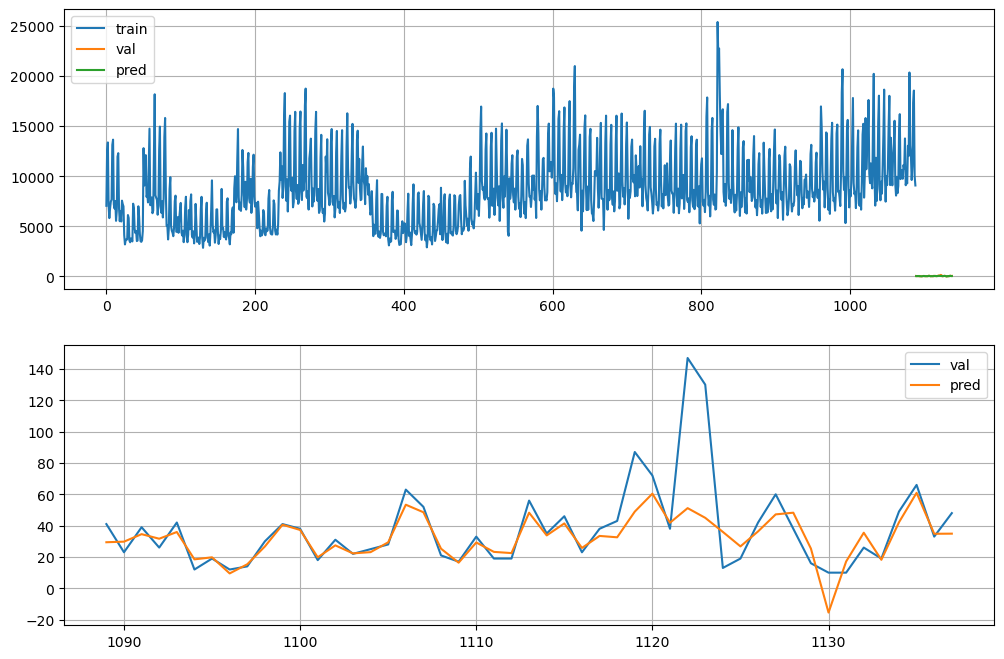

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
전체 수량:  673
MAE : 2.71
MAPE: 8.58 %
R2  : 0.8448
   year  month  week  weekday  season  is_weekend  CustomerCount         Qty  \
0  2014      1     1        3       3           0           4422   981.64400   
1  2014      1     1        4       3           0           4167  1278.90810   
2  2014      1     1        5       3           1           5341  1398.66600   
3  2014      1     1        6       3           1           5123  1119.53500   
4  2014      1     2        0       3           0           3917   526.12897   

        trend    seasonal  Target_Qty  
0  857.912581   98.812227  1398.66600  
1  857.912581  263.525166  1119.53500  
2  857.912581   59.448250   526.12897  
3  970.688581  -67.148382   700.50600  
4  925.282867 -199.148511   789.43200  
   year  month  week  weekday  season  is_weekend  CustomerCount        Qty  \
0  2017      3     9        2       0           0           4146   918.9270   
1  2017      3     9        3     

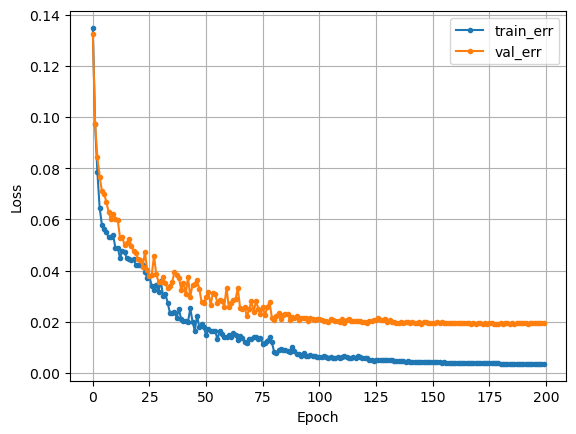

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Product_ID:  24
전체 수량:  49403
MAE : 21.20
MAPE: 2.20 %
R2  : 0.9934


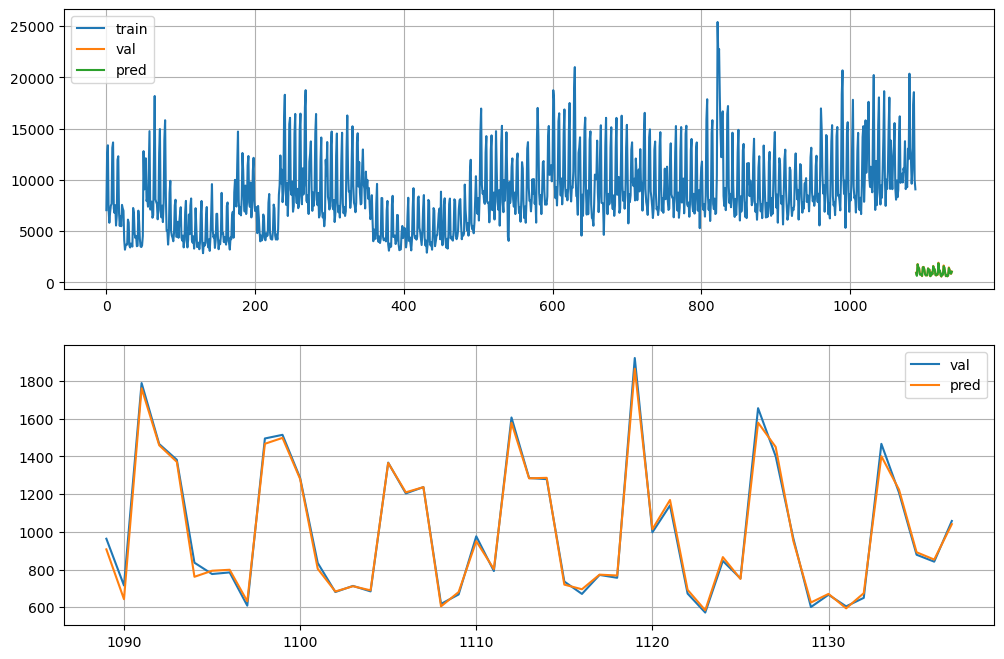

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  23026
MAE : 23.34
MAPE: 2.74 %
R2  : 0.9947
   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2014      1     1        3       3           0           4422  41.0   
1  2014      1     1        4       3           0           4167  40.0   
2  2014      1     1        5       3           1           5341  90.0   
3  2014      1     1        6       3           1           5123  96.0   
4  2014      1     2        0       3           0           3917  33.0   

       trend  seasonal  Target_Qty  
0  49.142857  2.524844        90.0  
1  49.142857  8.415291        96.0  
2  49.142857  3.062322        33.0  
3  58.857143 -0.533497        44.0  
4  60.714286 -4.149351        68.0  
   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2017      3     9        2       0           0           4146  28.0   
1  2017      3     9        3       0           0           3882  51.0   
2  2017      3     9 

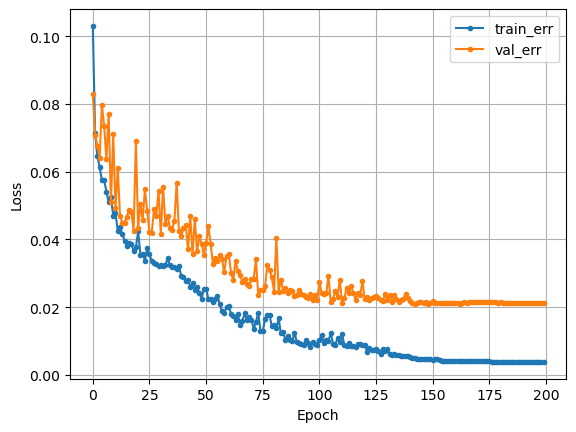

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Product_ID:  27
전체 수량:  1965
MAE : 1.79
MAPE: 5.72 %
R2  : 0.9781


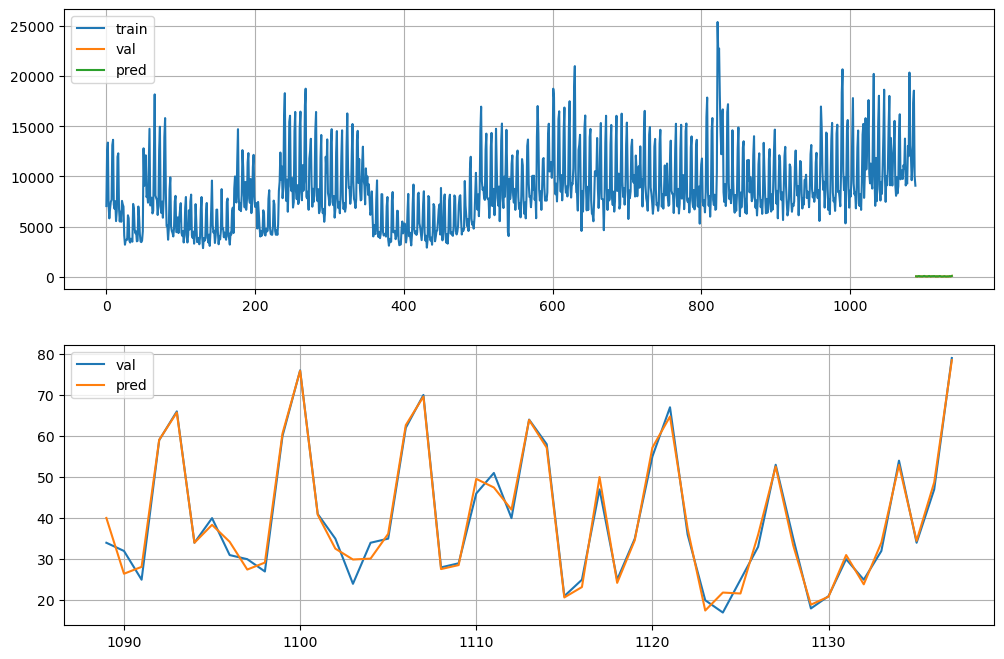

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  796
MAE : 2.50
MAPE: 8.36 %
R2  : 0.9534
   year  month  week  weekday  season  is_weekend  CustomerCount      Qty  \
0  2014      1     1        3       3           0           4422  654.149   
1  2014      1     1        4       3           0           4167  514.697   
2  2014      1     1        5       3           1           5341  749.997   
3  2014      1     1        6       3           1           5123  842.430   
4  2014      1     2        0       3           0           3917  494.158   

        trend   seasonal  Target_Qty  
0  531.754857  -2.369050     749.997  
1  531.754857  60.264351     842.430  
2  531.754857  70.886881     494.158  
3  620.379571  11.838725     466.853  
4  585.109000 -45.285217     620.373  
   year  month  week  weekday  season  is_weekend  CustomerCount        Qty  \
0  2017      3     9        2       0           0           4146  521.82000   
1  2017      3     9        3       0           0         

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  29
전체 수량:  25023
MAE : 5.22
MAPE: 1.08 %
R2  : 0.9952


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
전체 수량:  11309
MAE : 9.66
MAPE: 2.12 %
R2  : 0.9877
   year  month  week  weekday  season  is_weekend  CustomerCount       Qty  \
0  2014      1     1        3       3           0           4422  124.9780   
1  2014      1     1        4       3           0           4167  115.0889   
2  2014      1     1        5       3           1           5341  171.1640   
3  2014      1     1        6       3           1           5123  217.2520   
4  2014      1     2        0       3           0           3917   97.2330   

        trend   seasonal  Target_Qty  
0  117.277700   4.436629     171.164  
1  117.277700  30.067917     217.252  
2  117.277700  14.822130      97.233  
3  142.646129  -1.941262      95.228  
4  142.053271 -20.750274     177.579  
   year  month  week  weekday  season  is_weekend  CustomerCount         Qty  \
0  2017      3     9        2       0           0           4146  143.100000   
1  2017      3     9        3       0           

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  32
전체 수량:  5852
MAE : 3.05
MAPE: 2.92 %
R2  : 0.9877


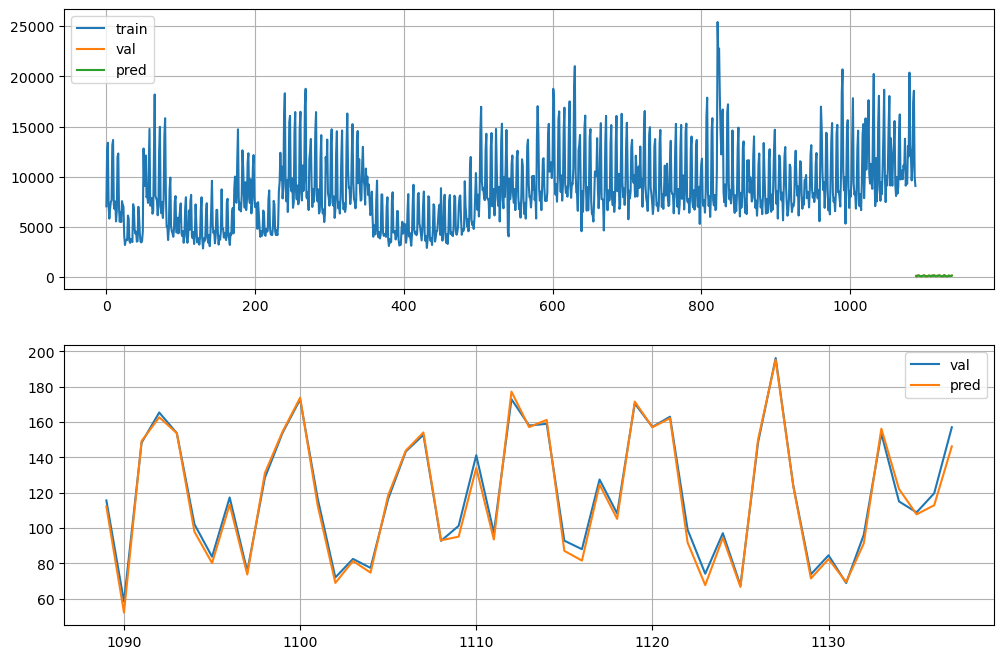

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
전체 수량:  3103
MAE : 3.94
MAPE: 3.00 %
R2  : 0.9860
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2014      1     1        3       3           0           4422  289.0   
1  2014      1     1        4       3           0           4167  333.0   
2  2014      1     1        5       3           1           5341  531.0   
3  2014      1     1        6       3           1           5123    0.0   
4  2014      1     2        0       3           0           3917  183.0   

        trend    seasonal  Target_Qty  
0  213.000000  144.338540       531.0  
1  213.000000  116.219347         0.0  
2  213.000000  -41.043982       183.0  
3  240.428571 -160.773947       155.0  
4  231.285714  -73.431612       192.0  
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2017      3     9        2       0           0           4146  235.0   
1  2017      3     9        3       0           0           3882  226.0

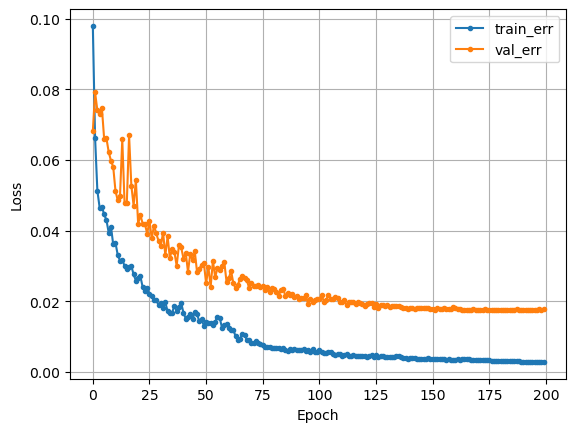

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Product_ID:  38
전체 수량:  14593
MAE : 10.71
MAPE: 325215513115468288.00 %
R2  : 0.9900


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
전체 수량:  7693
MAE : 20.20
MAPE: 6.45 %
R2  : 0.9727
   year  month  week  weekday  season  is_weekend  CustomerCount   Qty  \
0  2014      1     1        3       3           0           4422  76.0   
1  2014      1     1        4       3           0           4167  74.0   
2  2014      1     1        5       3           1           5341  78.0   
3  2014      1     1        6       3           1           5123  88.0   
4  2014      1     2        0       3           0           3917  65.0   

       trend   seasonal  Target_Qty  
0  72.857143  -0.937227        78.0  
1  72.857143   7.709985        88.0  
2  72.857143  13.207858        65.0  
3  76.000000  20.790125        78.0  
4  76.285714 -23.015624        73.0  
   year  month  week  weekday  season  is_weekend  CustomerCount    Qty  \
0  2017      3     9        2       0           0           4146  106.0   
1  2017      3     9        3       0           0           3882  138.0   
2  2017      

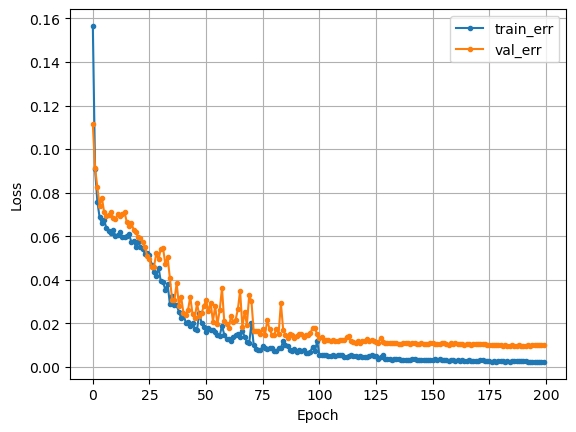

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Product_ID:  42
전체 수량:  4313
MAE : 0.66
MAPE: 0.77 %
R2  : 0.9968


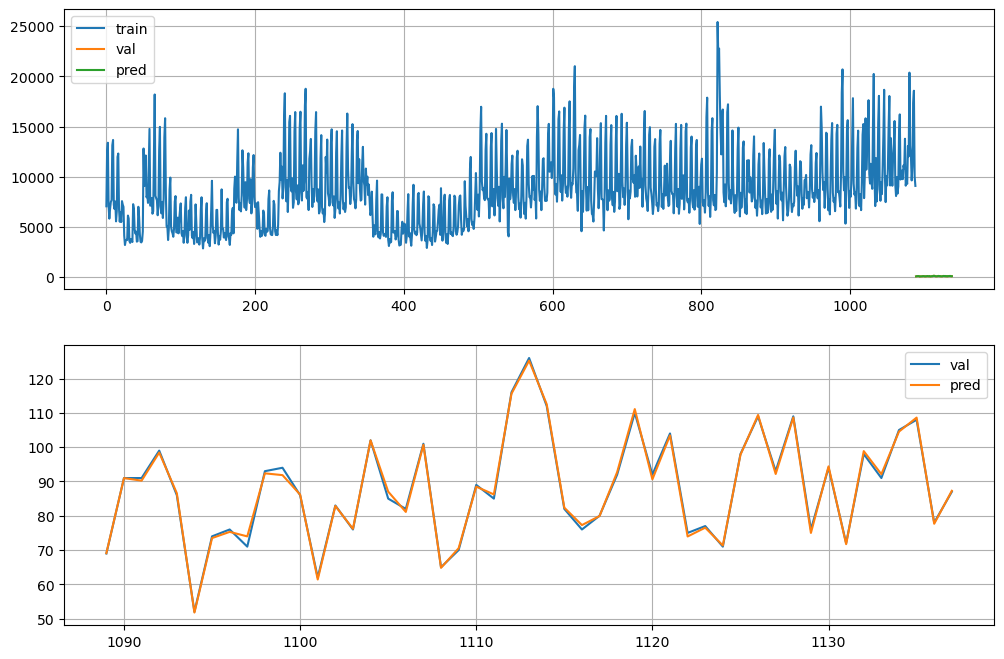

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
전체 수량:  2562
MAE : 2.58
MAPE: 2.30 %
R2  : 0.9635


In [187]:
from collections import defaultdict

Store_ID=44             # 44번 가게 
timesteps = 7           # 7일씩 예측 
Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']

all_pred_results = defaultdict()
all_pred_results_test = defaultdict()

for Product_ID in all_product_ID_list:

    x_train_s, x_val_s, y_train_s, y_val, x_test_s, y_test, scaler_x, scaler_y = \
        Total_Loader(oil_price, orders, sales, products, stores,
                    Selected_Features, timesteps = timesteps, Store_ID=Store_ID, Product_ID=Product_ID)
        
        
    model = training_process(timesteps, x_train_s, y_train_s, Epoch=200)
    pred = model.predict(x_val_s)

    # 예측 결과를 원래 스케일로 돌려 놓기
    pred = scaler_y.inverse_transform(pred)
    pred = pred.reshape(-1,)

    # 평가
    print('Product_ID: ', Product_ID)
    print('전체 수량: ', int(y_val.sum()))
    MAE = '{:.2f}'.format(mean_absolute_error(y_val, pred))
    MAPE = '{:.2f}'.format(mean_absolute_percentage_error(y_val, pred)*100)
    R2 = '{:.4f}'.format(r2_score(y_val, pred))
    print('MAE : {}'.format(MAE))
    print('MAPE: {} %'.format(MAPE))
    print('R2  : {}'.format(R2))
    
    all_pred_results[Product_ID] = [MAE,MAPE,R2]

    plot_model_result(y_train, y_val, pred)
    

    # 테스트셋 결과
    pred = model.predict(x_test_s)
    pred = scaler_y.inverse_transform(pred)
    pred = pred.reshape(-1,)
    print('전체 수량: ', int(y_test.sum()))
    MAE = '{:.2f}'.format(mean_absolute_error(y_test, pred))
    MAPE = '{:.2f}'.format(mean_absolute_percentage_error(y_test, pred)*100)
    R2 = '{:.4f}'.format(r2_score(y_test, pred))
    print('MAE : {}'.format(MAE))
    print('MAPE: {} %'.format(MAPE))
    print('R2  : {}'.format(R2))
    all_pred_results_test[Product_ID] = [MAE,MAPE,R2]
    
    

In [189]:
all_pred_results

defaultdict(None,
            {3: ['229.49', '2.25', '0.9938'],
             5: ['37.12', '2.15', '0.9913'],
             7: ['47.34', '1.81', '0.9900'],
             8: ['46.54', '1.62', '0.9946'],
             10: ['11.30', '1.85', '0.9940'],
             11: ['57.46', '13.63', '0.6946'],
             12: ['227.01', '2.26', '0.9920'],
             15: ['8.53', '7.67', '0.9830'],
             16: ['7.37', '7.09', '0.9393'],
             20: ['10.06', '28.10', '0.4176'],
             24: ['21.20', '2.20', '0.9934'],
             27: ['1.79', '5.72', '0.9781'],
             29: ['5.22', '1.08', '0.9952'],
             32: ['3.05', '2.92', '0.9877'],
             38: ['10.71', '325215513115468288.00', '0.9900'],
             42: ['0.66', '0.77', '0.9968']})

In [190]:
all_MAPE = []
for Product_ID in all_pred_results:
    print('---'*10)
    print(f'Product: {Product_ID}')
    print('MAE (수량오차):', all_pred_results[Product_ID][0])
    print('MAPE :{} %'.format(all_pred_results[Product_ID][1]))
    print('R2 (설명력):{}'.format(all_pred_results[Product_ID][1]))
    all_MAPE.append(float(all_pred_results[Product_ID][1]))
    

------------------------------
Product: 3
MAE (수량오차): 229.49
MAPE :2.25 %
R2 (설명력):2.25
------------------------------
Product: 5
MAE (수량오차): 37.12
MAPE :2.15 %
R2 (설명력):2.15
------------------------------
Product: 7
MAE (수량오차): 47.34
MAPE :1.81 %
R2 (설명력):1.81
------------------------------
Product: 8
MAE (수량오차): 46.54
MAPE :1.62 %
R2 (설명력):1.62
------------------------------
Product: 10
MAE (수량오차): 11.30
MAPE :1.85 %
R2 (설명력):1.85
------------------------------
Product: 11
MAE (수량오차): 57.46
MAPE :13.63 %
R2 (설명력):13.63
------------------------------
Product: 12
MAE (수량오차): 227.01
MAPE :2.26 %
R2 (설명력):2.26
------------------------------
Product: 15
MAE (수량오차): 8.53
MAPE :7.67 %
R2 (설명력):7.67
------------------------------
Product: 16
MAE (수량오차): 7.37
MAPE :7.09 %
R2 (설명력):7.09
------------------------------
Product: 20
MAE (수량오차): 10.06
MAPE :28.10 %
R2 (설명력):28.10
------------------------------
Product: 24
MAE (수량오차): 21.20
MAPE :2.20 %
R2 (설명력):2.20
------------------------------
P

In [191]:
# Valset에서 Store 44에서 전체 16개 상품의 2일 후 예측 수량 오차율
np.mean(all_MAPE)

2.0325969569716772e+16

In [188]:
all_pred_results_test

defaultdict(None,
            {3: ['787.85', '7.63', '0.9422'],
             5: ['126.38', '7.17', '0.9475'],
             7: ['100.12', '3.81', '0.9707'],
             8: ['87.05', '2.67', '0.9854'],
             10: ['27.22', '4.42', '0.9731'],
             11: ['76.88', '21.95', '0.1166'],
             12: ['518.37', '4.81', '0.9670'],
             15: ['5.78', '7.07', '0.9610'],
             16: ['42.62', '39.43', '0.6052'],
             20: ['2.71', '8.58', '0.8448'],
             24: ['23.34', '2.74', '0.9947'],
             27: ['2.50', '8.36', '0.9534'],
             29: ['9.66', '2.12', '0.9877'],
             32: ['3.94', '3.00', '0.9860'],
             38: ['20.20', '6.45', '0.9727'],
             42: ['2.58', '2.30', '0.9635']})

In [192]:
all_MAPE = []
for Product_ID in all_pred_results_test:
    print('---'*10)
    print(f'Product: {Product_ID}')
    print('MAE (수량오차):', all_pred_results[Product_ID][0])
    print('MAPE :{} %'.format(all_pred_results[Product_ID][1]))
    print('R2 (설명력):{}'.format(all_pred_results[Product_ID][1]))
    all_MAPE.append(float(all_pred_results[Product_ID][1]))
    

------------------------------
Product: 3
MAE (수량오차): 229.49
MAPE :2.25 %
R2 (설명력):2.25
------------------------------
Product: 5
MAE (수량오차): 37.12
MAPE :2.15 %
R2 (설명력):2.15
------------------------------
Product: 7
MAE (수량오차): 47.34
MAPE :1.81 %
R2 (설명력):1.81
------------------------------
Product: 8
MAE (수량오차): 46.54
MAPE :1.62 %
R2 (설명력):1.62
------------------------------
Product: 10
MAE (수량오차): 11.30
MAPE :1.85 %
R2 (설명력):1.85
------------------------------
Product: 11
MAE (수량오차): 57.46
MAPE :13.63 %
R2 (설명력):13.63
------------------------------
Product: 12
MAE (수량오차): 227.01
MAPE :2.26 %
R2 (설명력):2.26
------------------------------
Product: 15
MAE (수량오차): 8.53
MAPE :7.67 %
R2 (설명력):7.67
------------------------------
Product: 16
MAE (수량오차): 7.37
MAPE :7.09 %
R2 (설명력):7.09
------------------------------
Product: 20
MAE (수량오차): 10.06
MAPE :28.10 %
R2 (설명력):28.10
------------------------------
Product: 24
MAE (수량오차): 21.20
MAPE :2.20 %
R2 (설명력):2.20
------------------------------
P

In [193]:
# Testset에서 Store 44에서 전체 16개 상품의 2일 후 예측 수량 오차율
np.mean(all_MAPE)

2.0325969569716772e+16